**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [6]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python
!pip install -q h5py pyyaml 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = '173lssx5bG7u4iQQNtAJRYm4DNRsIupDK' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("tumor_075.tif")

file_id = '16aeh1alpL4Ql5SpNVwWYELakXPzH7Fd3' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("tumor_075_mask.tif")

file_id = '1d8cK43yey-yMZOtj-d0jWtFCBCZbqPLl' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("tumor_101.tif")

file_id = '1NzqLlzfdRDqN-7virUNpXqTh9efMPTba' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("tumor_101_mask.tif")

file_id = '1z2KHy-N7BQfpSoSZ1FS-pqOPR_e3eY6z' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("tumor_096.tif")

file_id = '1j7s-wypTS1xxktaJVcrH0YO1SjCl_9IB' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("tumor_096_mask.tif")

file_id = '1n2pIh-2-wTO0Er5YKye-84YEFsbpq2UH' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("tumor_094.tif")

file_id = '1ngSHKv9aM8irpP69lziNVYaEo5hxkDnP' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("tumor_094_mask.tif")

In [0]:
file_id = '11RzjCE_ySgk10IPAJEwv4bfgmaBT2dJP' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("tumor_091.tif")
file_id = '1hopHZjnPwR7IHMozgJDBre5rdvR_zx0Y' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("tumor_091_mask.tif")

In [0]:
def image_loader(slide_path,tumor_mask_path):
  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide.level_dimensions[3][0], 
                         height=slide.level_dimensions[3][1])
  mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=slide.level_dimensions[3][0], 
                        height=slide.level_dimensions[3][1])

  # Note: the program provided by the dataset authors generates a mask with R,G,B channels.
  # The mask info we need is in the first channel only.
  # If you skip this step, the mask will be displayed as all black.
  mask_image = mask_image[:,:,0]
  
  def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

  tissue_pixels = find_tissue_pixels(slide_image) #remove grey value > 0.8
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

  def apply_mask(im, mask, color=(255,0,0)): # set tissue areas as red
      masked = np.copy(im)
      for x,y in mask: masked[x][y] = color
      return masked

  tissue_regions = apply_mask(slide_image, tissue_pixels)
  return slide_image,mask_image,tissue_regions

In [4]:
slide_path = 'tumor_075.tif'
tumor_mask_path = 'tumor_075_mask.tif'
slide_image,mask_image,tissue_regions = image_loader(slide_path,tumor_mask_path)

Read WSI from tumor_075.tif with width: 90112, height: 78848
Read tumor mask from tumor_075_mask.tif
('Slide includes %d levels', 9)
Level 0, dimensions: (90112, 78848) downsample factor 1
Level 1, dimensions: (45056, 39424) downsample factor 2
Level 2, dimensions: (22528, 19712) downsample factor 4
Level 3, dimensions: (11264, 9856) downsample factor 8
Level 4, dimensions: (5632, 4928) downsample factor 16
Level 5, dimensions: (2816, 2464) downsample factor 32
Level 6, dimensions: (1408, 1232) downsample factor 64
Level 7, dimensions: (704, 616) downsample factor 128
Level 8, dimensions: (352, 308) downsample factor 256
14342126 tissue_pixels pixels (14.8 percent of the image)


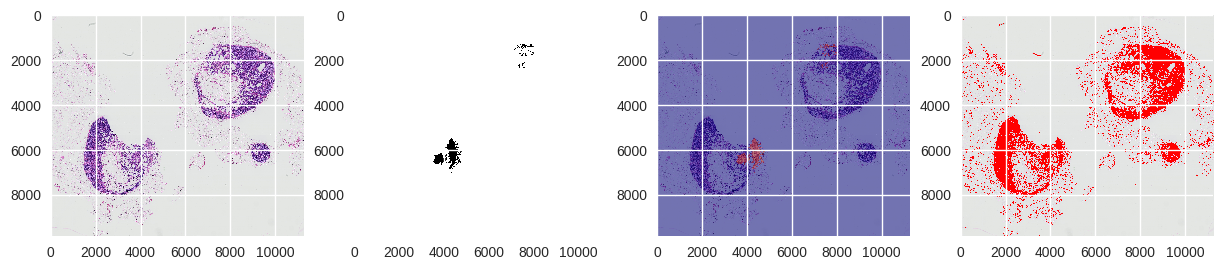

In [7]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,45),dpi=100)
ax1.imshow(slide_image)
ax2.imshow(mask_image)
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
ax3.imshow(slide_image)
ax3.imshow(mask_image, cmap='jet', alpha=0.5)
ax4.imshow(tissue_regions)

In [0]:
def get_patches(tissue_regions,mask_image):
  w = 299*(tissue_regions.shape[0] / 299 + 1)
  h = 299*(tissue_regions.shape[1] / 299 + 1)
  tissue_regions_padded = np.zeros((w,h,3))
  tissue_regions_padded[:tissue_regions.shape[0],:tissue_regions.shape[1],:] = tissue_regions
  
  mask_image_padded = np.zeros((299*(mask_image.shape[0] / 299 + 1),299*(mask_image.shape[1] / 299 + 1)))
  mask_image_padded[:mask_image.shape[0],:mask_image.shape[1]] = mask_image
  
#   print(mask_image_padded.shape,tissue_regions_padded.shape)
  #image processing
  #Start small (use a single slide, 
  #at the lowest available zoom level - 
  #the effective resolution should be on the order of 1,000 by 1,000 pixels).

  #Write code to slide a window across the slide.
  #Extract patches and labels (using the tissue mask).
  import math
  stepSize = 299
  (w_width, w_height) = (299, 299) # window size
  l,r = int(math.floor((299.0-128.0)/2)),int(math.ceil((299.0-128.0)/2))
  patches = []
  labels = []
  for x in range(0, tissue_regions_padded.shape[0] - w_width + 1, stepSize):
     for y in range(0, tissue_regions_padded.shape[1] - w_height + 1, stepSize):
        window = tissue_regions_padded[x:x + w_width, y:y + w_height, :]
        label = 1 if mask_image_padded[x+l:x + w_width-r, y+l:y + w_height-r].sum() > 0 else 0
        patches.append(window)
        labels.append(label)
  patches = np.asarray(patches)
  labels = np.asarray(labels)
  return patches,labels

In [11]:
slide_path = "tumor_091.tif"
tumor_mask_path = "tumor_091_mask.tif"
slide_image,mask_image,tissue_regions = image_loader(slide_path,tumor_mask_path)
X_train,y_train = get_patches(tissue_regions,mask_image)

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128
13344403 tissue_pixels pixels (29.6 percent of the image)


In [0]:
# slide_path = "tumor_094.tif"
# tumor_mask_path = "tumor_094_mask.tif"
# slide_image,mask_image,tissue_regions = image_loader(slide_path,tumor_mask_path)
# X_val,y_val = get_patches(tissue_regions,mask_image)

Read WSI from tumor_094.tif with width: 118784, height: 100352
Read tumor mask from tumor_094_mask.tif
('Slide includes %d levels', 9)
Level 0, dimensions: (118784, 100352) downsample factor 1
Level 1, dimensions: (59392, 50176) downsample factor 2
Level 2, dimensions: (29696, 25088) downsample factor 4
Level 3, dimensions: (14848, 12544) downsample factor 8
Level 4, dimensions: (7424, 6272) downsample factor 16
Level 5, dimensions: (3712, 3136) downsample factor 32
Level 6, dimensions: (1856, 1568) downsample factor 64
Level 7, dimensions: (928, 784) downsample factor 128
Level 8, dimensions: (464, 392) downsample factor 256
31150553 tissue_pixels pixels (19.8 percent of the image)


In [0]:
# slide_path = "tumor_096.tif"
# tumor_mask_path = "tumor_096_mask.tif"
# slide_image,mask_image,tissue_regions = image_loader(slide_path,tumor_mask_path)
# X_test,y_test = get_patches(tissue_regions,mask_image)

In [0]:
def undersampling(patches,labels):
  #First, we select “normal” or “tumor” with equal probability. 
  #Next, we select a slide that contains that class of patches uniformly at random, and sample patches from that slide.
  non_tumor_indices = np.where(labels == 0)[0]
  num_tumor = labels.sum()
  random_indices = np.random.choice(non_tumor_indices, num_tumor, replace=False)
  non_tumor_sample = patches[random_indices]
  non_tumor_label = labels[random_indices]
  
  tumor_indices = np.where(labels == 1)[0]
  tumor_sample = patches[tumor_indices]
  tumor_label = labels[tumor_indices]
  
  X = np.vstack((non_tumor_sample,tumor_sample))
  y = np.hstack((non_tumor_label,tumor_label))
  return X,y

In [0]:
X,y = undersampling(X_train,y_train)

In [20]:
X.shape

(32, 299, 299, 3)

In [0]:
#we apply several data augmentations. 
#First, we rotate the input patch by 4 multiples of 90◦, apply a left-right flip and repeat the rotations. 8 orientations in total.
#Next, we use TensorFlow’s image library (tensorflow.image.random X ) to perturb color:
#brightness with a maximum delta of 64/255, saturation with a maximum delta of 0.25, hue with a maximum delta of 0.04, and contrast with a maximum delta of 0.75.
#Lastly, we add jitter to the patch extraction process such that each patch has a small x,y offset of up to 8 pixels. 

In [17]:
X.shape

(32, 299, 299, 3)

In [0]:
X_aug = X
y_aug = y

In [0]:
X_aug.shape

(32, 299, 299, 3)

In [0]:
y_aug.shape

(32,)

In [0]:
import tensorflow as tf
# tf.enable_eager_execution()
X_rot = X
for i in range(4):
  X_rot = tf.image.rot90(X_rot)
  X_rot_np = tf.keras.backend.eval(X_rot)
#   X_rot_np = X_rot.numpy()
  X_aug = np.vstack((X_aug,X_rot_np))
  y_aug = np.hstack((y_aug,y))

In [0]:
X_flip = tf.image.flip_left_right(X)
X_flip_np = tf.keras.backend.eval(X_flip)
# X_flip_np = X_flip.numpy()
X_rot = X_flip_np
for i in range(4):
  X_rot = tf.image.rot90(X_rot)
  X_rot_np = tf.keras.backend.eval(X_rot)
#   X_rot_np = X_rot.numpy()
  X_aug = np.vstack((X_aug,X_rot_np))
  y_aug = np.hstack((y_aug,y))

In [24]:
X_aug.shape

(288, 299, 299, 3)

In [25]:
y_aug.shape

(288,)

In [0]:
X_color = tf.image.random_brightness(X_aug,64/255)
X_color_np = tf.keras.backend.eval(X_color)
# X_sat = tf.image.random_saturation(X_aug,lower = 0, upper=0.25)
# X_sat_np = tf.keras.backend.eval(X_sat)
# X_hue = tf.image.random_hue(X_aug,0.04)
# X_hue_np = tf.keras.backend.eval(X_hue)
# X_con = tf.image.random_contrast(X_aug,0.75)
# X_con_np = tf.keras.backend.eval(X_con)

In [0]:
X_aug = np.vstack((X_aug,X_color_np))
y_aug = np.hstack((y_aug,y_aug))
# X_aug = np.vstack((X_aug,X_sat_np))
# y_aug_new = np.hstack((y_aug_new,y_aug))
# X_aug = np.vstack((X_aug,X_hue_np))
# y_aug = np.hstack((y_aug,y))
# X_aug = X_aug.vstack((X_aug,X_con_np))
# y_aug = np.hstack((y_aug,y))

In [28]:
X_aug.shape,y_aug.shape

((576, 299, 299, 3), (576,))

In [0]:
X_aug = X_aug.astype('float32') / 255

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
# create the  base pre-trained model
base_model = VGG16(weights='imagenet',
                  include_top=False, input_shape=(299, 299, 3))

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
base_model.trainable = False
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               10617088  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 25,332,033
Trainable params: 10,617,345
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
from sklearn.metrics import roc_auc_score
import tensorflow as tf
def auc( y_true, y_pred ) :
    score = tf.py_func( lambda y_true, y_pred : roc_auc_score( y_true, y_pred, average='macro', sample_weight=None).astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        stateful=False,
                        name='sklearnAUC' )
    return score

In [36]:
from tensorflow.keras import optimizers
import tensorflow as tf

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy',auc])
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                min_delta=0.01,
#                                                patience=0,
#                                                verbose=1)
history = model.fit(X_train, y_train,
                    epochs=5,
                   validation_data=(X_test, y_test),
                   callbacks = [cp_callback])
#                     callbacks=[early_stopping])

Train on 460 samples, validate on 116 samples
Epoch 1/5
448/460 [============================>.] - ETA: 0s - loss: 0.4299 - acc: 0.8125 - auc: 0.9203
Epoch 00001: saving model to training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
460/460 [==============================] - 23s 50ms/step - loss: 0.4337 - acc: 0.8065 - auc: 0.9166 - val_loss: 0.3252 - val_acc: 0.9138 - val_auc: 0.9717
Epoch 2/5
448/460 [============================>.] - ETA: 0s - loss: 0.2671 - acc: 0.9196 - auc: 0.9694
Epoch 00002: saving model to training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
460/460 [==============================] - 11s 23ms/step - loss: 0.2619 - acc: 0.9217 - auc: 0.9702 - val_loss: 0.2836 - val_acc: 0.8879 - val_auc: 0.9839
Epoch 3/5
448/460 [============================>.] - ETA: 0s - loss: 0.2136 - acc: 0.9308 - auc: 0.9877
Epoch 00003: saving model to training_1/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
460/460 [===========

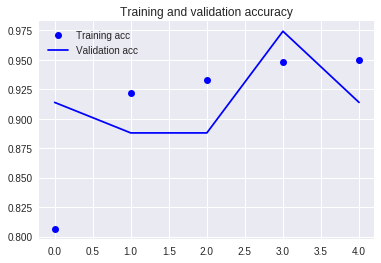

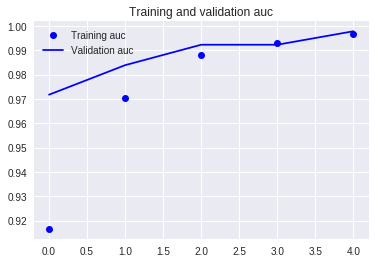

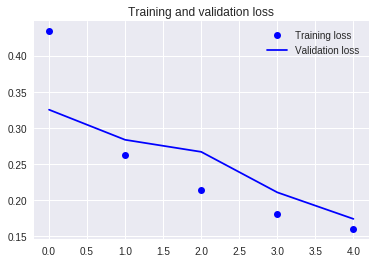

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

auc = history.history['auc']
val_auc = history.history['val_auc']
plt.figure()
plt.plot(epochs, auc, 'bo', label='Training auc')
plt.plot(epochs, val_auc, 'b', label='Validation auc')
plt.title('Training and validation auc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [38]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5).astype(int)
confusion_matrix(y_test, y_pred)

array([[44, 10],
       [ 0, 62]])

In [39]:
slide_path = "tumor_075.tif"
tumor_mask_path = "tumor_075_mask.tif"
slide_image,mask_image,tissue_regions = image_loader(slide_path,tumor_mask_path)
X_test,y_test = get_patches(tissue_regions,mask_image)

Read WSI from tumor_075.tif with width: 90112, height: 78848
Read tumor mask from tumor_075_mask.tif
('Slide includes %d levels', 9)
Level 0, dimensions: (90112, 78848) downsample factor 1
Level 1, dimensions: (45056, 39424) downsample factor 2
Level 2, dimensions: (22528, 19712) downsample factor 4
Level 3, dimensions: (11264, 9856) downsample factor 8
Level 4, dimensions: (5632, 4928) downsample factor 16
Level 5, dimensions: (2816, 2464) downsample factor 32
Level 6, dimensions: (1408, 1232) downsample factor 64
Level 7, dimensions: (704, 616) downsample factor 128
Level 8, dimensions: (352, 308) downsample factor 256
14342126 tissue_pixels pixels (14.8 percent of the image)


In [0]:
X_test = X_test.astype('float32') / 255

In [62]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob>0.5).astype(int)
confusion_matrix(y_test, y_pred)

array([[1161,   67],
       [  19,    7]])

In [64]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
print("acc",accuracy_score(y_test, y_pred))
print("roc",roc_auc_score(y_test,y_pred_prob))

('acc', 0.9314194577352473)
('roc', 0.857585818090704)


In [43]:
X_test.shape

(1254, 299, 299, 3)

In [42]:
len(y_pred)

1254

In [0]:
row, col = np.ceil(np.asarray(mask_image.shape, dtype=np.float32)/299).astype('int').tolist()
y_img = y_pred.reshape(row, col)

Text(0.5,1,u'True Label Cancer Region')

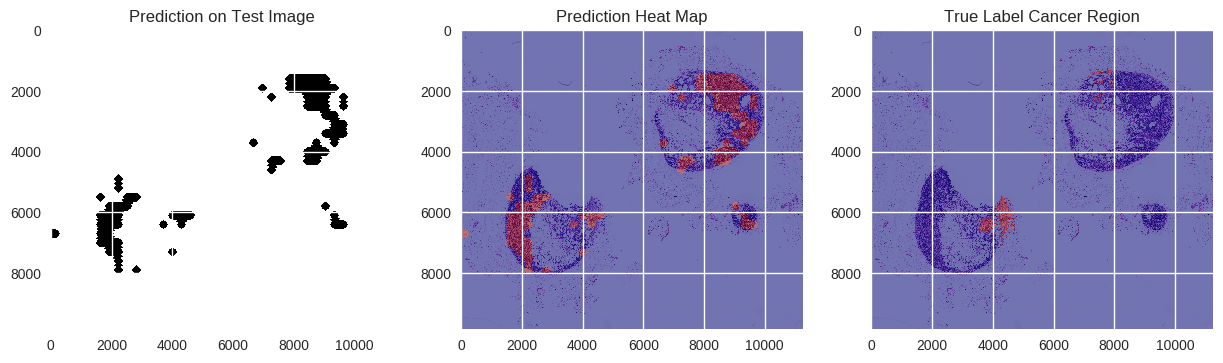

In [54]:
import cv2
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,45),dpi=100)
dim = (11264, 9856)
resized_image =cv2.resize(y_img.astype(np.uint8), dim) 
ax1.imshow(resized_image)
ax1.set_title("Prediction on Test Image")

ax2.imshow(slide_image)
ax2.imshow(resized_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
ax2.set_title("Prediction Heat Map")


ax3.imshow(slide_image)
ax3.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
ax3.set_title("True Label Cancer Region")